In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import gc

## Gaussian NB for spam.csv:

In [2]:
class GaussianNB:
    
    def __init__(self):
        pass
        
    def fit(self, data, labels):
        self.classes, self.prior = np.unique(labels, return_counts=True)
        self.prior = np.divide(self.prior, self.prior.sum())
        self.n_classes = len(self.classes)
        self.mu = np.zeros((self.n_classes, data.shape[1]))
        self.sigma = np.zeros((self.n_classes, data.shape[1]))
        for i in range(self.n_classes):
            self.mu[i, :] = data[labels==self.classes[i]].mean(axis=0)
            self.sigma[i, :] = data[labels==self.classes[i]].std(axis=0)

    def predict_proba(self, data):
        exp_ = - np.power(data[:, np.newaxis] - self.mu, 2)/(2*np.power(self.sigma, 2))
        likelihood = np.prod(np.exp(exp_)/(self.sigma * np.sqrt(2*np.pi)), axis=2)
        posterior = np.multiply(likelihood, self.prior)
        norm_coeff = posterior.sum(axis=1)
        posterior[norm_coeff != 0] = posterior[norm_coeff != 0]/norm_coeff[norm_coeff != 0].reshape(-1, 1)
        return posterior
    
    def predict(self, data, th=0.5):
        posterior = self.predict_proba(data)
        return (posterior[:, 1]>th).astype(int)
    
def assess(model, data, labels, th=0.5):
    posterior = model.predict_proba(data)
    preds = (posterior>th).astype(int)
    acc = round(accuracy_score(labels, preds[:, 1]), 3)
    auc = round(roc_auc_score(labels, posterior[:, 1]), 3)
    fpr, tpr, _ = roc_curve(labels, posterior[:, 1])
    fig, ax = plt.subplots(figsize=[7, 7])
    ax.plot(fpr, tpr, label=f'Accuracy = {acc}\nROC AUC = {auc}')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_title(model.__class__.__name__)
    ax.legend()
    ax.grid()

In [3]:
df = pd.read_csv('Data/spam.csv')
labels_spam = df['label'].values
data_spam = df.drop(columns='label').values

In [4]:
X_tr_spam, X_te_spam, y_tr_spam, y_te_spam = train_test_split(data_spam,
                                                              labels_spam,
                                                              test_size=0.2, 
                                                              stratify=labels_spam)

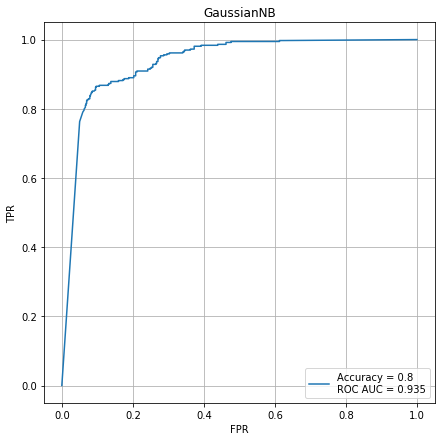

In [5]:
GNB = GaussianNB()
GNB.fit(X_tr_spam, y_tr_spam)
assess(GNB, X_te_spam, y_te_spam)

## Multinomial NB for smsspam.csv:

In [17]:
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin, BaseEstimator

class Preprocesser(TransformerMixin):
    
    def __init__(self, tokenizer='bow'):
        
        self.stemmer = SnowballStemmer('english')
        if tokenizer == 'bow':
            self.tokenizer = CountVectorizer()
        elif tokenizer == 'tfidf':
            self.tokenizer = TfidfVectorizer()
        else:
            raise ValueError('Vectoriztion method is not supported')
            
    def stem_text(self, text):
        text = text.split(' ')
        stemmed = [self.stemmer.stem(word) for word in text]
        stemmed = ' '.join(stemmed)
        return stemmed
    
    def fit(self, text_series, y=None):
        stemmed_series = text_series.apply(self.stem_text)
        vectorized = self.tokenizer.fit(stemmed_series)
        return self
        
    def transform(self, text_series, y=None):
        stemmed_series = text_series.apply(self.stem_text)
        vectorized = self.tokenizer.transform(stemmed_series)
        return vectorized
    
class MultinomialNB(BaseEstimator):
    
    def __init__(self, alpha=0.05):
        self.prior = None
        self.params = None
        self.alpha = alpha
        
    def fit(self, data, labels):
        data = data.toarray()
        self.classes, self.prior = np.unique(labels, return_counts=True)
        self.prior = np.divide(self.prior, self.prior.sum())
        self.n_classes = len(self.classes)
        self.max_count = np.max(data)
        self.prob_mat = np.zeros((self.n_classes, data.shape[1], self.max_count+1))
        self.class_counts = np.bincount(labels)
        for i in self.classes:
            temp = np.apply_along_axis(lambda x: np.bincount(x, minlength=self.max_count+1),
                                       axis=0, 
                                       arr=data[labels==i]).T
            temp = (temp + self.alpha)/(self.class_counts[i] + self.alpha * (self.max_count + 1))
            self.prob_mat[i] = temp
        return self
    
    def get_likelihood(self, vec):
        return np.product(self.prob_mat[:, self.ll_index, vec], axis=1).reshape(-1, 1)
        
    def predict_proba(self, data):
        data = data.toarray()
        
        if np.max(data) > self.max_count:
            print('There are counts larger than in train')
            new_max = np.max(data)
            to_app = np.zeros((self.prob_mat.shape[0], 
                               self.prob_mat.shape[1],
                               new_max - self.max_count))
            self.prob_mat = self.prob_mat * (self.class_counts[:,np.newaxis, np.newaxis] + \
                                             self.alpha * (self.max_count + 1)) - \
                                             self.alpha
            self.prob_mat = np.concatenate([self.prob_mat, to_app], axis=2)
            self.prob_mat = (self.prob_mat + self.alpha)/(self.class_counts[:, np.newaxis, np.newaxis] + \
                                                 self.alpha * (new_max + 1))
            self.max_count = new_max
        
        self.ll_index = np.arange(self.prob_mat.shape[1])
        LL = np.apply_along_axis(self.get_likelihood, axis=1, arr=data)
        LL = np.squeeze(np.swapaxes(LL, 0, 1), axis=2)
        posterior = np.multiply(LL, self.prior.reshape(2, -1)).T
        norm_coeff = posterior.sum(axis=1)
        posterior[norm_coeff != 0] = posterior[norm_coeff != 0]/norm_coeff[norm_coeff != 0].reshape(-1, 1)
        return posterior
        
    def predict(self, data):
        posterior = self.predict_proba(data)
        return (posterior[:, 1]>th).astype(int)

In [7]:
sms = pd.read_csv('Data/smsspam.csv')
sms['label'], sms_enc = pd.factorize(sms['label'])
print(sms.shape)
print(sms_enc)
labels_sms = sms['label']
text_sms = sms['text']
sms.head(10)

(5572, 2)
Index(['ham', 'spam'], dtype='object')


,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


In [18]:
X_tr_sms, X_te_sms, y_tr_sms, y_te_sms = train_test_split(text_sms, 
                                                          labels_sms, 
                                                          test_size=0.2,
                                                          stratify=labels_sms)

In [19]:
pipe = make_pipeline(Preprocesser(), MultinomialNB())

In [20]:
_ = pipe.fit(X_tr_sms, y_tr_sms)

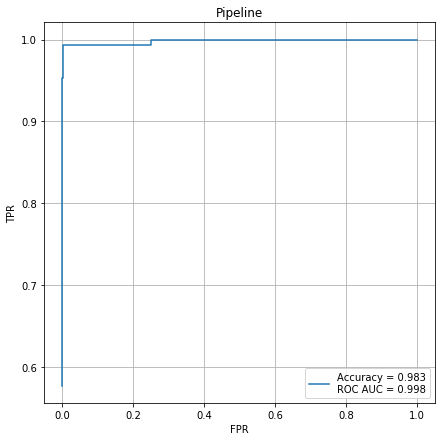

In [21]:
assess(pipe, X_te_sms, y_te_sms)